In [1]:
import pandas as pd
import numpy as np
import os
import glob
from config import load_config
paths = load_config(dataset_key='all')
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import csv
import h5py
import json

Paths are for dataset tagged: all


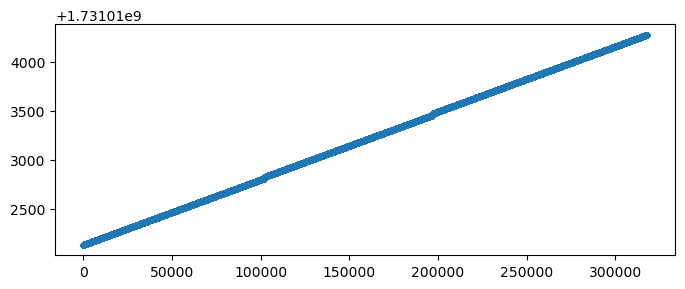

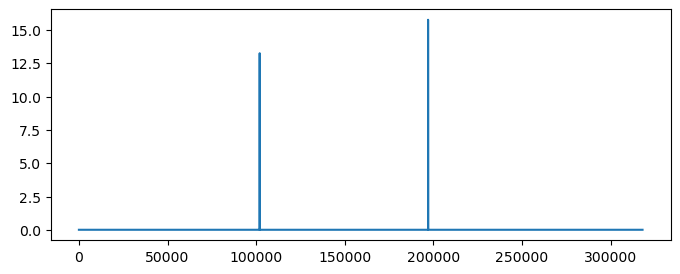

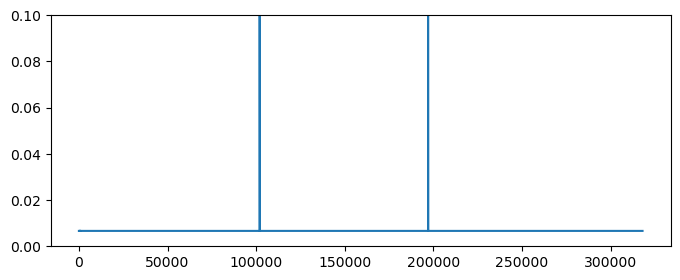

In [2]:
# Load HSFP preprocessed hdf5 file 
f = h5py.File(paths['raw_data'] / 'hsfp_data_preprocessed.hdf5','r')
time_405 = np.array(f['Time_405'])
time_445 = np.array(f['Time_445'])
time_473 = np.array(f['Time_473'])
time_514 = np.array(f['Time_514'])
time_560 = np.array(f['Time_560'])
timestamps = np.array(f['Full_TimeStamps'])
lasers = np.array(f['Lasers'])
wavelength = np.array(f['Wavelength'])
L_405_F1 = np.array(f['Channel_405_F1'])
L_405_F2 = np.array(f['Channel_405_F2'])
L_445_F1 = np.array(f['Channel_445_F1'])
L_445_F2 = np.array(f['Channel_445_F2'])
L_473_F1 = np.array(f['Channel_473_F1'])
L_473_F2 = np.array(f['Channel_473_F2'])
L_514_F1 = np.array(f['Channel_514_F1'])
L_514_F2 = np.array(f['Channel_514_F2'])
L_560_F1 = np.array(f['Channel_560_F1'])
L_560_F2 = np.array(f['Channel_560_F2'])
# Plot figure with camTrigger 
plt.figure(figsize=(8,3))
plt.plot(timestamps,'.')
plt.show()
plt.figure(figsize=(8,3))
plt.plot(np.diff(timestamps))
plt.show()
plt.figure(figsize=(8,3))
plt.plot(np.diff(timestamps))
plt.ylim(0,0.1)
plt.show()


In [3]:
# Read harp event file for the timing input from the hamamatsu camera

from datetime import datetime
from enum import IntEnum
from os import PathLike
from typing import Any, BinaryIO, Optional, Union

import numpy as np
import pandas as pd
from pandas._typing import Axes

REFERENCE_EPOCH = datetime(1904, 1, 1)
"""The reference epoch for UTC harp time."""


class MessageType(IntEnum):
    """Specifies the type of a Harp message."""

    NA = 0
    READ = 1
    WRITE = 2
    EVENT = 3


_SECONDS_PER_TICK = 32e-6
_messagetypes = [type.name for type in MessageType]
_payloadtypes = {
    1: np.dtype(np.uint8),
    2: np.dtype(np.uint16),
    4: np.dtype(np.uint32),
    8: np.dtype(np.uint64),
    129: np.dtype(np.int8),
    130: np.dtype(np.int16),
    132: np.dtype(np.int32),
    136: np.dtype(np.int64),
    68: np.dtype(np.float32),
}

def read(
    file: Union[str, bytes, PathLike[Any], BinaryIO],
    address: Optional[int] = None,
    dtype: Optional[np.dtype] = None,
    length: Optional[int] = None,
    columns: Optional[Axes] = None,
    epoch: Optional[datetime] = None,
    keep_type: bool = False,
):
    """Read single-register Harp data from the specified file.

    Parameters
    ----------
    file
        Open file object or filename containing binary data from
        a single device register.
    address
        Expected register address. If specified, the address of
        the first message in the file is used for validation.
    dtype
        Expected data type of the register payload. If specified, the
        payload type of the first message in the file is used for validation.
    length
        Expected number of elements in register payload. If specified, the
        payload length of the first message in the file is used for validation.
    columns
        The optional column labels to use for the data values.
    epoch
        Reference datetime at which time zero begins. If specified,
        the result data frame will have a datetime index.
    keep_type
        Specifies whether to include a column with the message type.

    Returns
    -------
        A pandas data frame containing message data, sorted by time.
    """
    data = np.fromfile(file, dtype=np.uint8)
    if len(data) == 0:
        return pd.DataFrame(columns=columns, index=pd.Index([], dtype=np.float64, name="Time"))

    if address is not None and address != data[2]:
        raise ValueError(f"expected address {address} but got {data[2]}")

    index = None
    stride = int(data[1] + 2)
    nrows = len(data) // stride
    payloadtype = data[4]
    payloadoffset = 5
    if payloadtype & 0x10 != 0:
        seconds = np.ndarray(nrows, dtype=np.uint32, buffer=data, offset=payloadoffset, strides=stride)
        payloadoffset += 4
        micros = np.ndarray(nrows, dtype=np.uint16, buffer=data, offset=payloadoffset, strides=stride)
        payloadoffset += 2
        time = micros * _SECONDS_PER_TICK + seconds
        payloadtype = payloadtype & ~np.uint8(0x10)
        if epoch is not None:
            time = epoch + pd.to_timedelta(time, "s")  # type: ignore
        index = pd.Series(time)
        index.name = "Time"

    payloadsize = stride - payloadoffset - 1
    payloadtype = _payloadtypes[payloadtype]
    if dtype is not None and dtype != payloadtype:
        raise ValueError(f"expected payload type {dtype} but got {payloadtype}")

    elementsize = payloadtype.itemsize
    payloadshape = (nrows, payloadsize // elementsize)
    if length is not None and length != payloadshape[1]:
        raise ValueError(f"expected payload length {length} but got {payloadshape[1]}")

    payload = np.ndarray(
        payloadshape,
        dtype=payloadtype,
        buffer=data,
        offset=payloadoffset,
        strides=(stride, elementsize),
    )

    result = pd.DataFrame(payload, index=index, columns=columns)
    if keep_type:
        msgtype = np.ndarray(nrows, dtype=np.uint8, buffer=data, offset=0, strides=stride)
        msgtype = pd.Categorical.from_codes(msgtype, categories=_messagetypes)  # type: ignore
        result[MessageType.__name__] = msgtype
    return result

# Read the binary file as a data frame
data_frame = read(paths['raw_data'] / 'Event_32.bin')

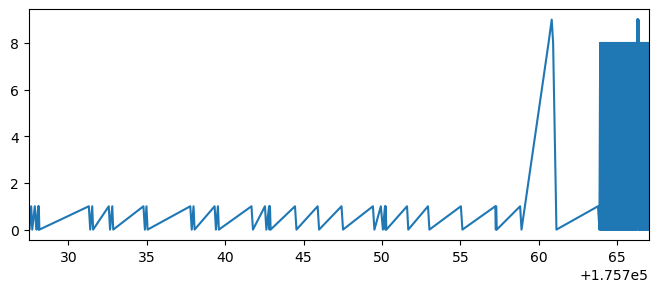

[1 0 1 ... 0 1 0]
[0.056064 0.108608 0.06848  ... 0.003392 0.0024   0.14384 ]
First occurrence of the pattern:
Start index: 70, Stop index: 73
Last occurrence of the pattern:
Start index: 651412, Stop index: 651415
Camera trigger time: 175763.912032
Camera trigger time: 36.45523199997842 sec


In [4]:
# Convert the event data to numpy arrays and find the camera trigger start time

event_times = np.array(data_frame.index)
event_values = np.array(data_frame[0])

# Plot the event data
plt.figure(figsize=(8,3))
plt.plot(event_times, event_values)
plt.xlim(event_times[0], event_times[1000])
plt.show()


print(event_values)
d = (np.diff(event_times))
print(d)

# Define your vector
x = d #np.array([0.5, 2.7, 3.99, 2.66, 4.01, 2.66, 4, 2.66, 9, 10, 11])

# Define the target pattern with tolerance
target_pattern = [0.004, 0.00266, 0.004, 0.00266]
tolerance = 0.0001  # Define a tolerance for the matching

# Function to check if values match the pattern within tolerance
def matches_pattern(sub_array, pattern, tol):
    return all(np.isclose(sub_array[i], pattern[i], atol=tol) for i in range(len(pattern)))

# Initialize variables for first and last occurrence
first_start_index, first_stop_index = None, None
last_start_index, last_stop_index = None, None

# Loop through the vector to find the first and last occurrences
for i in range(len(x) - len(target_pattern) + 1):
    # Check if the slice of x matches the pattern within the tolerance
    if matches_pattern(x[i:i+len(target_pattern)], target_pattern, tolerance):
        # For the first occurrence, set the start and stop indices
        if first_start_index is None:
            first_start_index = i
            first_stop_index = i + len(target_pattern) - 1
        # Update the last occurrence each time a match is found
        last_start_index = i
        last_stop_index = i + len(target_pattern) - 1

# Print the results
if first_start_index is not None and last_start_index is not None:
    print("First occurrence of the pattern:")
    print(f"Start index: {first_start_index}, Stop index: {first_stop_index}")
    print("Last occurrence of the pattern:")
    print(f"Start index: {last_start_index}, Stop index: {last_stop_index}")
else:
    print("Pattern not found")\
    
camera_trigger_index = first_start_index
camera_trigger_time = event_times[camera_trigger_index]
print(f"Camera trigger time: {camera_trigger_time}")
print(f"Camera trigger time: {camera_trigger_time-event_times[0]} sec")

In [5]:
# Find where the camera trigger is in the harp time

# Example: time vector on clock 1 (in seconds, for instance)
clock1_times = timestamps  # Replace with your actual clock 1 time vector
# Calculate the time differences between consecutive frames on clock 1
time_diffs = np.diff(clock1_times)
# Start time for clock 2
clock2_start_time = camera_trigger_time  # Replace with your actual start time on clock 2
# Generate clock 2 times by adding cumulative sum of time differences to start time
harp_timestamps = np.insert(np.cumsum(time_diffs), 0, 0) + clock2_start_time
print(harp_timestamps)

# Generate the timestamp for each laser from the hsfp times

def convert_hsfp_to_harp_time(hsfp_timestamps, harp_timestamps, hsfp_time):
    """
    Converts HSFP timestamps to Harp timestamps.
    Parameters:
    hsfp_timestamps (np.array): The HSFP timestamps.
    harp_timestamps (np.array): The Harp timestamps.
    hsfp_time (float): The HSFP time to convert.
    Returns:
    float: The Harp time.
    """
    harp_time = np.zeros(len(hsfp_time))
    for i in range(len(hsfp_time)):
        # Find the index of the closest HSFP timestamp
        hsfp_index = np.searchsorted(hsfp_timestamps, hsfp_time[i])
        harp_time[i] = harp_timestamps[hsfp_index]
    return harp_time

# Convert each laser hsfp time to harp time
harp_time_405 = convert_hsfp_to_harp_time(timestamps, harp_timestamps, time_405)
harp_time_445 = convert_hsfp_to_harp_time(timestamps, harp_timestamps, time_445)
harp_time_473 = convert_hsfp_to_harp_time(timestamps, harp_timestamps, time_473)
harp_time_514 = convert_hsfp_to_harp_time(timestamps, harp_timestamps, time_514)
harp_time_560 = convert_hsfp_to_harp_time(timestamps, harp_timestamps, time_560)


[175763.912032   175763.91868722 175763.92534219 ... 177909.46411716
 177909.47077214 177909.47742712]


In [6]:
# Load and parse json file for behavior

jsonfiles = glob.glob(os.path.join(paths['raw_data'],'*.json'))
print(jsonfiles)

behavior_jsonfile = jsonfiles[0]
with open(behavior_jsonfile) as f:
    data = json.load(f)
    print(data.keys())

['Z:\\smrithi.sunil\\data-upload\\HSFP_741062_2024-11-07_12-42-06\\fib\\741062_2024-11-07_12-41-04.json']
dict_keys(['TP_', 'TP_AddOneTrialForNoresponse', 'TP_AdvancedBlockAuto', 'TP_AlignToGoCue', 'TP_ArcAngle', 'TP_AutoControl', 'TP_AutoReward', 'TP_AutoTrain', 'TP_AutoWaterType', 'TP_BaseRewardSum', 'TP_BaseWeight', 'TP_BlockBeta', 'TP_BlockMax', 'TP_BlockMin', 'TP_BlockMinReward', 'TP_Clear', 'TP_ClearMetadata', 'TP_ConditionP_1', 'TP_ConditionP_2', 'TP_ConditionP_3', 'TP_ConditionP_4', 'TP_ConditionP_5', 'TP_ConditionP_6', 'TP_Condition_1', 'TP_Condition_2', 'TP_Condition_3', 'TP_Condition_4', 'TP_Condition_5', 'TP_Condition_6', 'TP_DelayBeta', 'TP_DelayMax', 'TP_DelayMin', 'TP_Duration_1', 'TP_Duration_2', 'TP_Duration_3', 'TP_Duration_4', 'TP_Duration_5', 'TP_Duration_6', 'TP_EphysProbes', 'TP_Experimenter', 'TP_FIPMode', 'TP_FractionOfSession', 'TP_FrameRate', 'TP_Frequency_1', 'TP_Frequency_2', 'TP_Frequency_3', 'TP_Frequency_4', 'TP_Frequency_5', 'TP_Frequency_6', 'TP_Fundee'

In [7]:
# Detrent the hsfp data with a 4th order polynomial

def detrend_signal(signal):
    x = np.arange(len(signal))
    p = np.polyfit(x,signal,5)
    y = np.polyval(p,x)
    signal_detrended = signal - y + np.mean(signal)
    return signal_detrended

L_405_F1_detrend = np.zeros(np.shape(L_405_F1))
L_405_F2_detrend = np.zeros(np.shape(L_405_F2))
L_445_F1_detrend = np.zeros(np.shape(L_445_F1))
L_445_F2_detrend = np.zeros(np.shape(L_445_F2))
L_473_F1_detrend = np.zeros(np.shape(L_473_F1))
L_473_F2_detrend = np.zeros(np.shape(L_473_F2))
L_514_F1_detrend = np.zeros(np.shape(L_514_F1))
L_514_F2_detrend = np.zeros(np.shape(L_514_F2))
L_560_F1_detrend = np.zeros(np.shape(L_560_F1))
L_560_F2_detrend = np.zeros(np.shape(L_560_F2))
for i in range(len(L_560_F2[0,:])):
    L_405_F1_detrend[:,i] = detrend_signal(L_405_F1[:,i])
    L_405_F2_detrend[:,i] = detrend_signal(L_405_F2[:,i])
    L_445_F1_detrend[:,i] = detrend_signal(L_445_F1[:,i])
    L_445_F2_detrend[:,i] = detrend_signal(L_445_F2[:,i])
    L_473_F1_detrend[:,i] = detrend_signal(L_473_F1[:,i])
    L_473_F2_detrend[:,i] = detrend_signal(L_473_F2[:,i])
    L_514_F1_detrend[:,i] = detrend_signal(L_514_F1[:,i])
    L_514_F2_detrend[:,i] = detrend_signal(L_514_F2[:,i])
    L_560_F1_detrend[:,i] = detrend_signal(L_560_F1[:,i])
    L_560_F2_detrend[:,i] = detrend_signal(L_560_F2[:,i])

# Calculate z-scores for each detrended trace
z_405_F1 = (L_405_F1_detrend - np.mean(L_405_F1_detrend,axis=0))/np.std(L_405_F1_detrend,axis=0)
z_405_F2 = (L_405_F2_detrend - np.mean(L_405_F2_detrend,axis=0))/np.std(L_405_F2_detrend,axis=0)
z_445_F1 = (L_445_F1_detrend - np.mean(L_445_F1_detrend,axis=0))/np.std(L_445_F1_detrend,axis=0)
z_445_F2 = (L_445_F2_detrend - np.mean(L_445_F2_detrend,axis=0))/np.std(L_445_F2_detrend,axis=0)
z_473_F1 = (L_473_F1_detrend - np.mean(L_473_F1_detrend,axis=0))/np.std(L_473_F1_detrend,axis=0)
z_473_F2 = (L_473_F2_detrend - np.mean(L_473_F2_detrend,axis=0))/np.std(L_473_F2_detrend,axis=0)
z_514_F1 = (L_514_F1_detrend - np.mean(L_514_F1_detrend,axis=0))/np.std(L_514_F1_detrend,axis=0)
z_514_F2 = (L_514_F2_detrend - np.mean(L_514_F2_detrend,axis=0))/np.std(L_514_F2_detrend,axis=0)
z_560_F1 = (L_560_F1_detrend - np.mean(L_560_F1_detrend,axis=0))/np.std(L_560_F1_detrend,axis=0)
z_560_F2 = (L_560_F2_detrend - np.mean(L_560_F2_detrend,axis=0))/np.std(L_560_F2_detrend,axis=0)

# # Calculate deltaF/F for each detrended trace
# dF_F_405_F1 = ((L_405_F1_detrend/np.mean(L_405_F1_detrend,axis=0))-1)*100
# dF_F_405_F2 = ((L_405_F2_detrend/np.mean(L_405_F2_detrend,axis=0))-1)*100
# dF_F_445_F1 = ((L_445_F1_detrend/np.mean(L_445_F1_detrend,axis=0))-1)*100
# dF_F_445_F2 = ((L_445_F2_detrend/np.mean(L_445_F2_detrend,axis=0))-1)*100
# dF_F_473_F1 = ((L_473_F1_detrend/np.mean(L_473_F1_detrend,axis=0))-1)*100
# dF_F_473_F2 = ((L_473_F2_detrend/np.mean(L_473_F2_detrend,axis=0))-1)*100
# dF_F_514_F1 = ((L_514_F1_detrend/np.mean(L_514_F1_detrend,axis=0))-1)*100
# dF_F_514_F2 = ((L_514_F2_detrend/np.mean(L_514_F2_detrend,axis=0))-1)*100
# dF_F_560_F1 = ((L_560_F1_detrend/np.mean(L_560_F1_detrend,axis=0))-1)*100
# dF_F_560_F2 = ((L_560_F2_detrend/np.mean(L_560_F2_detrend,axis=0))-1)*100



Text(0.5, 1.0, 'z-score, Ex: 560 nm')

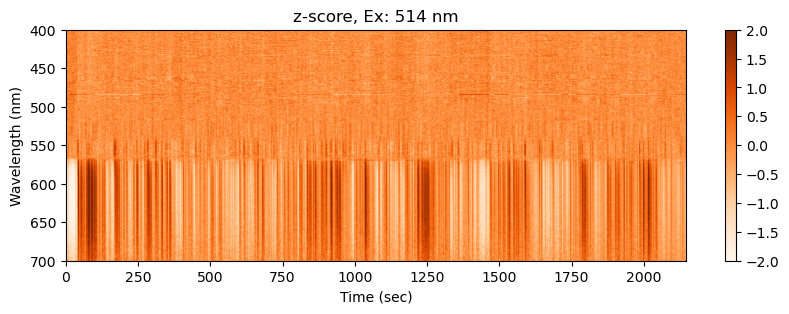

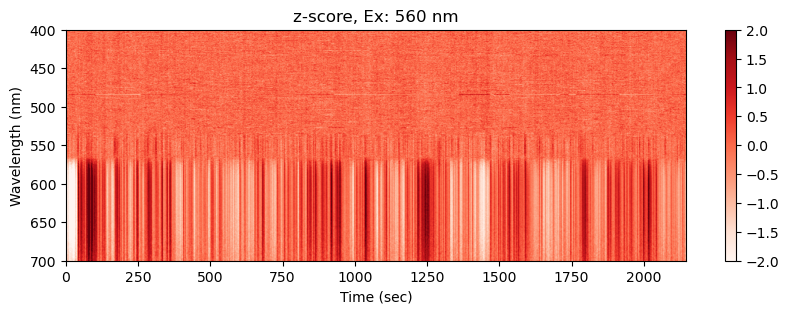

In [8]:
# Plot spectrogram of wavelength over time

plt.figure(figsize=(10,3))
t = harp_time_514-harp_time_514[0]
plt.imshow(np.transpose(z_514_F2),aspect='auto',cmap='Oranges',vmin=-2,vmax=2,extent=[t[0],t[-1],700,400])
plt.colorbar()
plt.xlabel('Time (sec)')
plt.ylabel('Wavelength (nm)')
plt.title('z-score, Ex: 514 nm')

plt.figure(figsize=(10,3))
t = harp_time_560-harp_time_560[0]
plt.imshow(np.transpose(z_560_F2),aspect='auto',cmap='Reds',vmin=-2,vmax=2,extent=[t[0],t[-1],700,400])
plt.colorbar()
plt.xlabel('Time (sec)')
plt.ylabel('Wavelength (nm)')
plt.title('z-score, Ex: 560 nm')


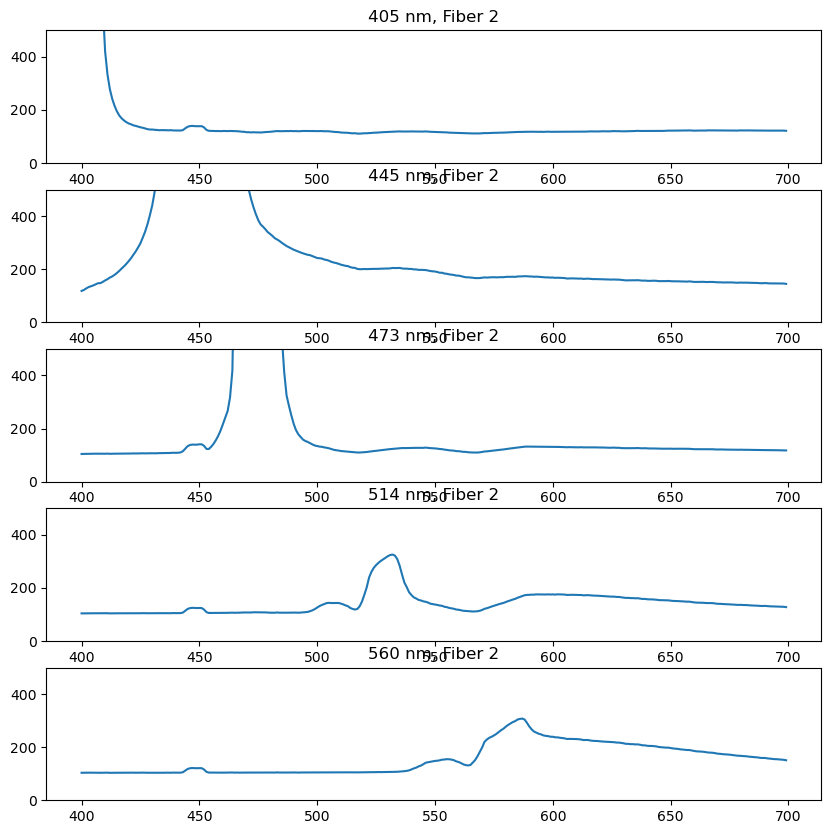

In [43]:
# Plot the spectrum of the signal

spec_405_F1 = np.mean(L_405_F1,axis=0)
spec_405_F2 = np.mean(L_405_F2,axis=0)
spec_445_F1 = np.mean(L_445_F1,axis=0)
spec_445_F2 = np.mean(L_445_F2,axis=0)
spec_473_F1 = np.mean(L_473_F1,axis=0)
spec_473_F2 = np.mean(L_473_F2,axis=0)
spec_514_F1 = np.mean(L_514_F1,axis=0)
spec_514_F2 = np.mean(L_514_F2,axis=0)
spec_560_F1 = np.mean(L_560_F1,axis=0)
spec_560_F2 = np.mean(L_560_F2,axis=0)

# Plot as subplots
plt.figure(figsize=(10,10))
plt.subplot(5,1,1)
plt.plot(wavelength,spec_405_F2)
plt.ylim(0,500)
plt.title('405 nm, Fiber 2')
plt.subplot(5,1,2)
plt.plot(wavelength,spec_445_F2)
plt.ylim(0,500)
plt.title('445 nm, Fiber 2')
plt.subplot(5,1,3)
plt.plot(wavelength,spec_473_F2)
plt.ylim(0,500)
plt.title('473 nm, Fiber 2')
plt.subplot(5,1,4)
plt.plot(wavelength,spec_514_F2)
plt.ylim(0,500)
plt.title('514 nm, Fiber 2')
plt.subplot(5,1,5)
plt.plot(wavelength,spec_560_F2)
plt.ylim(0,500)
plt.title('560 nm, Fiber 2')
plt.show()


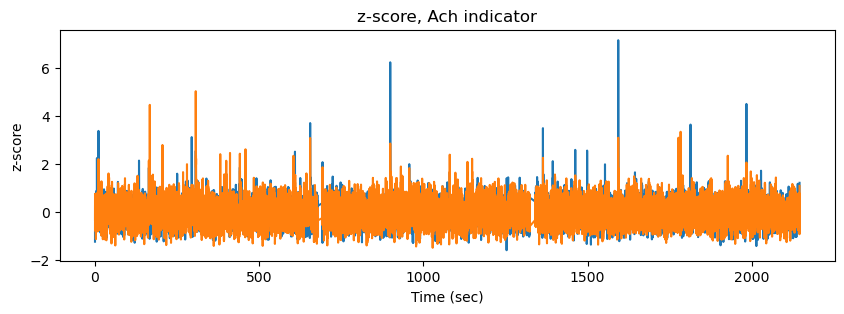

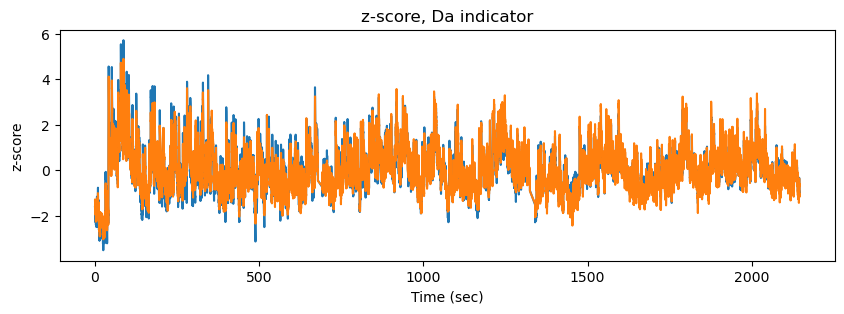

In [9]:
# Pull out ranges for indicator data

Ach_F1 = np.mean(z_514_F1[:,540-400:550-400], axis=1)
Ach_F2 = np.mean(z_514_F2[:,540-400:550-400], axis=1)
Da_F1 = np.mean(z_560_F1[:,590-400:610-400], axis=1)
Da_F2 = np.mean(z_560_F2[:,590-400:610-400], axis=1)

# Plot indicator data

plt.figure(figsize=(10,3))
plt.plot(harp_time_514-harp_time_514[0],Ach_F1)
plt.plot(harp_time_514-harp_time_514[0],Ach_F2)
plt.xlabel('Time (sec)')
plt.ylabel('z-score')
plt.title('z-score, Ach indicator')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(harp_time_560-harp_time_560[0],Da_F1)
plt.plot(harp_time_560-harp_time_560[0],Da_F2)
plt.xlabel('Time (sec)')
plt.ylabel('z-score')
plt.title('z-score, Da indicator')
plt.show()



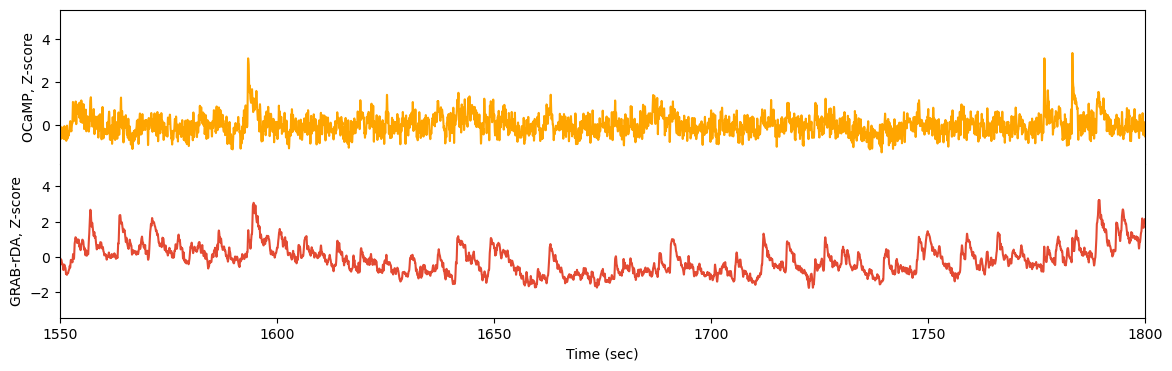

In [10]:
# Plot three indicators in one plot

# set figure size
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14,4), gridspec_kw={'hspace': 0})  # hspace=0 removes vertical space

ax1.plot(harp_time_514-harp_time_514[0],Ach_F2,color='#FFA500')
ax1.get_xaxis().set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('OCaMP, Z-score')

ax2.plot(harp_time_560-harp_time_560[0],Da_F2,color='#e34a33')
ax2.spines['top'].set_visible(False)
ax2.set_xlabel('Time (sec)')
ax2.set_ylabel('GRAB-rDA, Z-score')

for ax in (ax1, ax2):
    ax.set_xlim(1550,1800)

plt.show()

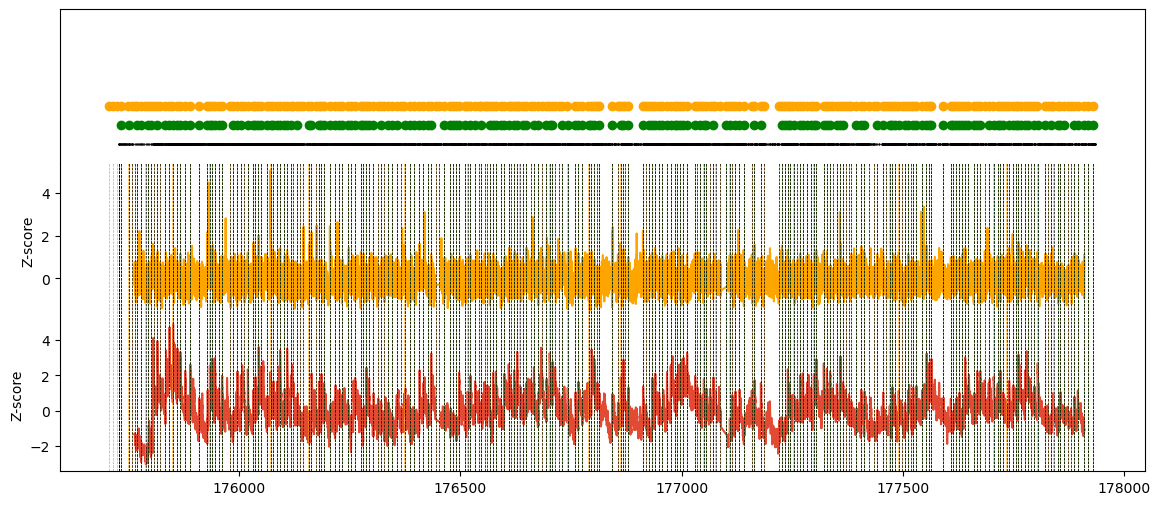

In [11]:
# Plot single trial data

gocue_times = np.array(data['B_GoCueTime'])
reward_times = np.array(data['B_LeftRewardDeliveryTimeHarp'])
lick_times = np.array(data['B_LeftLickTime'])

# set figure size
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14,6), gridspec_kw={'hspace': 0})  # hspace=0 removes vertical space

ax1.plot(gocue_times, 3*np.ones(len(gocue_times)),'o',color='orange')
ax1.plot(reward_times, 2*np.ones(len(reward_times)),'o',color='green')
ax1.plot(lick_times, 1*np.ones(len(lick_times)),'.',color='black',markersize=1)
ax1.set_ylim(0,8)
# Remove x-axis from the first plot to avoid duplicate x-axis labels
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.plot(harp_time_473,Ach_F2,color='#FFA500')
# Draw a thin line at gocue, reward
for i in range(len(gocue_times)):
    ax2.axvline(x=gocue_times[i], color='orange', linestyle='--', linewidth=0.5)
for i in range(len(reward_times)):
    ax2.axvline(x=reward_times[i], color='green', linestyle='--', linewidth=0.5)
# Draw line only at the first lick after gocue for each gocue
lick_times_gocue = []
for i in range(len(gocue_times)):
    lick_times_gocue.append(lick_times[np.argmax(lick_times>gocue_times[i])])
for i in range(len(lick_times_gocue)):
    ax2.axvline(x=lick_times_gocue[i], color='black', linestyle='--', linewidth=0.5)
ax2.get_xaxis().set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_ylabel('Z-score')

ax3.plot(harp_time_514,Da_F2,color='#e34a33')
# Draw a thin line at gocue, reward
for i in range(len(gocue_times)):
    ax3.axvline(x=gocue_times[i], color='orange', linestyle='--', linewidth=0.5)
for i in range(len(reward_times)):
    ax3.axvline(x=reward_times[i], color='green', linestyle='--', linewidth=0.5)
# Draw line only at the first lick after gocue for each gocue
lick_times_gocue = []
for i in range(len(gocue_times)):
    lick_times_gocue.append(lick_times[np.argmax(lick_times>gocue_times[i])])
for i in range(len(lick_times_gocue)):
    ax3.axvline(x=lick_times_gocue[i], color='black', linestyle='--', linewidth=0.5)
ax3.spines['top'].set_visible(False)
ax3.set_ylabel('Z-score')

# for ax in (ax2, ax3, ax4):
#     ax.set_ylim(-3, 4)
# for ax in (ax1, ax2, ax3):
#     ax.set_xlim(81800, 82300)
#     ax.set_xlim(1209800, 1210280)
#     ax.set_xlim(1117200, 1117500)
#     ax.set_xlim(773200, 773600)
#    ax.set_xlim(518500, 518670)
#    ax.set_xlim(166700, 166900)

# Adjust layout to remove any extra margin around the subplots
#plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0)

plt.show()

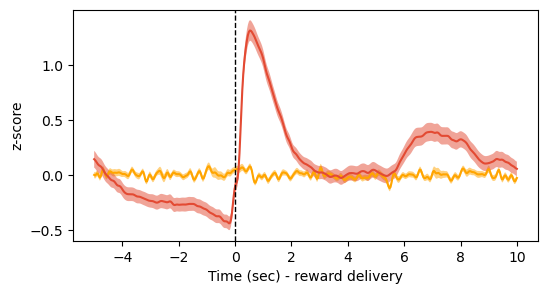

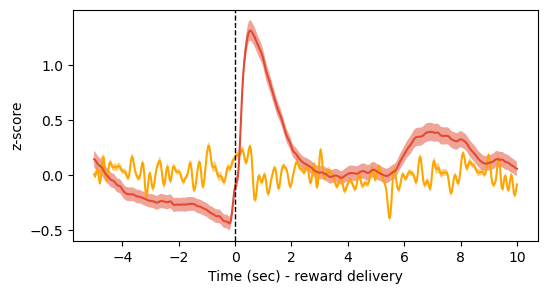

In [12]:
# Align imaging data to behavior events - go cue

gocue_times = np.array(data['B_GoCueTime'])
del gocue_times
gocue_times = np.array(data['B_LeftRewardDeliveryTime'])

# Extract imaging segments 5 seconds before and 10 seconds after go cue
DAimaging_segments = []
Achimaging_segments = []
Caimaging_segments = []
count = 0
l = np.zeros(len(gocue_times))
for gocue_time in gocue_times:
    start_time = gocue_time - 5
    end_time = gocue_time + 10
    start_index = np.searchsorted(harp_time_560, start_time)
    end_index = np.searchsorted(harp_time_560, end_time)
    l[count] = end_index-start_index
    Achimaging_segments.append(Ach_F1[start_index:end_index])
    DAimaging_segments.append(Da_F1[start_index:end_index])
    count+=1

# Find all the imaging segments with length 449-451
idx = np.where((l>449) & (l<452))
Achsegments = []
DAsegments = []
for i in idx[0]:
    temp = Achimaging_segments[i][0:449]
    Achsegments.append(temp)
    temp = DAimaging_segments[i][0:449]
    DAsegments.append(temp)

Ach_array = np.array(Achsegments)
DA_array = np.array(DAsegments)

# Plot the mean and ste of aligned imaging data

mAch = np.mean(Ach_array,axis=0)
sAch = np.std(Ach_array,axis=0)/np.sqrt(len(Ach_array))
mDA = np.mean(DA_array,axis=0)
sDA = np.std(DA_array,axis=0)/np.sqrt(len(DA_array))

t = np.linspace(-5,10,449)
plt.figure(figsize=(6,3))
plt.plot(t,mAch,color='#FFA500')
plt.fill_between(t,mAch-sAch,mAch+sAch,alpha=0.5,color='#FFA500',edgecolor='none')
plt.plot(t,mDA,color='#e34a33')
plt.fill_between(t,mDA-sDA,mDA+sDA,alpha=0.5,color='#e34a33',edgecolor='none')
# Draw a thin line at t=0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Time (sec) - reward delivery')
plt.ylabel('z-score')
plt.show()

t = np.linspace(-5,10,449)
plt.figure(figsize=(6,3))
plt.plot(t,3.3*mAch,color='#FFA500')
plt.fill_between(t,3.3*mAch-sAch,3.3*mAch+sAch,alpha=0.5,color='#FFA500',edgecolor='none')
plt.plot(t,mDA,color='#e34a33')
plt.fill_between(t,mDA-sDA,mDA+sDA,alpha=0.5,color='#e34a33',edgecolor='none')
# Draw a thin line at t=0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Time (sec) - reward delivery')
plt.ylabel('z-score')
plt.show()